In [1]:
from datetime import datetime, date

import ibis
import numpy as np
import pandas as pd
# local
from settings import conf
from utils import cursor2df
from gen_data import salary_date, salary_date_schema

### Data

In [2]:
df_salary1 = salary_date()
print(df_salary1.dtypes)
df_salary1

last_name                     object
salary                       float64
date_of_birth                 object
timestamp_of_birth    datetime64[ns]
dtype: object


,last_name,salary,date_of_birth,timestamp_of_birth
0,Name 2010 1 1,2010011.0,2010-01-01,2010-01-01 01:01:01.010101
1,Name 2011 1 1,2011011.0,2011-01-01,2011-01-01 01:01:01.010101
2,Name 2012 1 1,2012011.0,2012-01-01,2012-01-01 01:01:01.010101
3,Name 2013 1 1,2013011.0,2013-01-01,2013-01-01 01:01:01.010101
4,Name 2014 1 1,2014011.0,2014-01-01,2014-01-01 01:01:01.010101
...,...,...,...,...
4013,Name 2016 12 31,2016151.0,2016-12-31,2016-12-31 12:12:12.121231
4014,Name 2017 12 31,2017151.0,2017-12-31,2017-12-31 12:12:12.121231
4015,Name 2018 12 31,2018151.0,2018-12-31,2018-12-31 12:12:12.121231
4016,Name 2019 12 31,2019151.0,2019-12-31,2019-12-31 12:12:12.121231


In [3]:
sch = salary_date_schema()
sch

ibis.Schema {  
  last_name           string
  salary              float64
  date_of_birth       date
  timestamp_of_birth  timestamp
}

In [4]:
con = {}
expr = {}
df = {}
result = {}
expected = {}
table_name = 'salary'

### OmniSciDB

In [5]:
con['omniscidb'] = ibis.omniscidb.connect(**conf['omniscidb'])

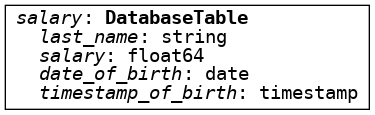

In [6]:
con['omniscidb'].drop_table(table_name, force=True)
con['omniscidb'].create_table(table_name, schema=sch)
con['omniscidb'].load_data(table_name, df_salary1)
t = con['omniscidb'].table(table_name)
t

In [7]:
df['omniscidb'] = t.execute()

In [8]:
# https://stackoverflow.com/a/29263010
def _ibis_p(year):
    return (
        year + (year // 4) - (year // 100) + (year // 400) 
    ) % 7

def ibis_n_weeks_year(year):
    return 52 + (
        ibis.case()
        .when((_ibis_p(year) == 4) | (_ibis_p(year - 1) == 3), 1)
        .else_(0)
        .end()
    )

def ibis_woy_preliminary(d):
    # https://en.wikipedia.org/wiki/ISO_week_date
    doy = d.day_of_year()
    y = d.year()
    dow = d.day_of_week.index() + 1
    
    result = doy - dow
    result += 10
    return (result // 7).cast('int16')

def ibis_woy(d):
    w = ibis_woy_preliminary(d)
    y = d.year()
    
    one = ibis.literal(1, type='int16')
    
    return (
        ibis.case()
        .when(w < one, ibis_n_weeks_year(y - one))
        .when(w > ibis_n_weeks_year(y), one)
        .else_(w)
        .end()
    )

expr['omniscidb'] = ibis_woy(t.timestamp_of_birth).name('tmp')
print(expr['omniscidb'].compile())
result['omniscidb'] = expr['omniscidb'].execute()
expected['omniscidb'] = df['omniscidb'].timestamp_of_birth.dt.weekofyear.astype('int16')
np.testing.assert_array_equal(result['omniscidb'].values, expected['omniscidb'].values)

SELECT
  CASE
    WHEN CAST(floor(((EXTRACT(DOY FROM "timestamp_of_birth") - (EXTRACT(ISODOW FROM "timestamp_of_birth")- 1 + 1)) + 10) / 7) AS SMALLINT) < 1 THEN CASE WHEN ((mod((((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 4)) - floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 100)) + floor((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) / 400), 7)) = 4) OR ((mod(((((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) + floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 4)) - floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 100)) + floor(((EXTRACT(YEAR FROM "timestamp_of_birth") - 1) - 1) / 400), 7)) = 3) THEN 1 ELSE 0 END + 52
    WHEN CAST(floor(((EXTRACT(DOY FROM "timestamp_of_birth") - (EXTRACT(ISODOW FROM "timestamp_of_birth")- 1 + 1)) + 10) / 7) AS SMALLINT) > (CASE WHEN ((mod(((EXTRACT(YEAR FROM "timestamp_of_birth") + floor(EXTRACT(YEAR FROM "timestamp_of_birth") / 4)) - floor(EXTRACT(YEAR FROM "tim